Load BigGAN model from PyTorch to TF2.  
Based on code from [huggingface](https://github.com/huggingface/pytorch-pretrained-BigGAN/tree/master/pytorch_pretrained_biggan).

In [14]:
config = {
  # file location for caching pretrained biggan
  'torch_dir': './',
  # location for saving tf2 weights
  'tf2_file': 'biggan-tf2-256/weights',

  # image size (either 128, 256, or 512)
  'im_sz': 256,

  # biggan parameters (do not change)
  'z_dim': 128, 
  'num_classes': 1000,
  'class_embed_dim': 128, 
  'channel_width': 128, 
  'n_stats': 51,
  'attention_layer_position': 8,
  'eps': 1e-4
}

# parameters for biggan with for different image sizes (do not change)
layers_dict = {
  '128': [(False, 16, 16),
          (True, 16, 16),
          (False, 16, 16),
          (True, 16, 8),
          (False, 8, 8),
          (True, 8, 4),
          (False, 4, 4),
          (True, 4, 2),
          (False, 2, 2),
          (True, 2, 1)],

  '256': [(False, 16, 16),
          (True, 16, 16),
          (False, 16, 16),
          (True, 16, 8),
          (False, 8, 8),
          (True, 8, 8),
          (False, 8, 8),
          (True, 8, 4),
          (False, 4, 4),
          (True, 4, 2),
          (False, 2, 2),
          (True, 2, 1)],

  '512': [(False, 16, 16),
          (True, 16, 16),
          (False, 16, 16),
          (True, 16, 8),
          (False, 8, 8),
          (True, 8, 8),
          (False, 8, 8),
          (True, 8, 4),
          (False, 4, 4),
          (True, 4, 2),
          (False, 2, 2),
          (True, 2, 1),
          (False, 1, 1),
          (True, 1, 1)]
}

# layer architecture (in_filters, out_filters, upsample_bool)
config['layers'] = layers_dict[str(config['im_sz'])]

In [2]:
##############################
# ## BIG GAN in TF2 Keras ## #
##############################

# code adapted from: https://github.com/huggingface/pytorch-pretrained-BigGAN/blob/master/pytorch_pretrained_biggan/

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras

import math


def snconv2d(**kwargs):
    return tfa.layers.SpectralNormalization(keras.layers.Conv2D(**kwargs))

def snlinear(**kwargs):
    return tfa.layers.SpectralNormalization(keras.layers.Dense(**kwargs))

class SelfAttn(keras.layers.Layer):
    """ Self attention Layer"""
    def __init__(self, in_channels):
        super(SelfAttn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(filters=in_channels//8, kernel_size=1, use_bias=False)
        self.snconv1x1_phi = snconv2d(filters=in_channels//8, kernel_size=1, use_bias=False)
        self.snconv1x1_g = snconv2d(filters=in_channels//2, kernel_size=1, use_bias=False)
        self.snconv1x1_o_conv = snconv2d(filters=in_channels, kernel_size=1, use_bias=False)

        self.maxpool = keras.layers.MaxPooling2D()
        self.softmax  = keras.layers.Softmax()
        self.gamma = self.add_weight(name='gamma', shape=(1,), trainable=True)

    def call(self, x, training=False):
        _, h, w, ch = tuple(x.shape)

        # Theta path
        theta = self.snconv1x1_theta(x, training=training)
        theta = tf.reshape(theta, [-1, h*w, ch//8])
        # Phi path
        phi = self.snconv1x1_phi(x, training=training)
        phi = self.maxpool(phi)
        phi = tf.reshape(phi, [-1, h*w//4, ch//8])
        # Attn map
        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x, training=training)
        g = self.maxpool(g)
        g = tf.reshape(g, (-1, h*w//4, ch // 2))
        # Attn_g - o_conv
        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, (-1, h, w, ch//2))
        attn_g = self.snconv1x1_o_conv(attn_g, training=training)
        # Out
        out = x + self.gamma * attn_g

        return out

class BigGANBatchNorm(keras.layers.Layer):
    def __init__(self, num_features, n_stats=51, eps=1e-4, conditional=True):
        super(BigGANBatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.conditional = conditional

        self.means = self.add_weight(name='mean', shape=(n_stats, num_features), trainable=False)
        self.vars = self.add_weight(name='var', shape=(n_stats, num_features), trainable=False)
        self.step_size = 1.0 / (n_stats - 1)

        if conditional:
            self.scale = snlinear(units=num_features, use_bias=False)
            self.offset = snlinear(units=num_features, use_bias=False)
        else:
            self.weight = self.add_weight(name='w', shape=(num_features,), trainable=False)
            self.bias = self.add_weight(name='b', shape=(num_features,), trainable=False)

    def call(self, x, truncation, condition_vector=None, training=False):
        # Retreive pre-computed statistics associated to this truncation
        coef, start_idx = math.modf(truncation / self.step_size)
        start_idx = int(start_idx)
        if coef != 0.0:  # Interpolate
            running_mean = self.means[start_idx] * coef + self.means[start_idx + 1] * (1 - coef)
            running_var = self.vars[start_idx] * coef + self.vars[start_idx + 1] * (1 - coef)
        else:
            running_mean = self.means[start_idx]
            running_var = self.vars[start_idx]

        if self.conditional:
            running_mean = tf.reshape(running_mean, [1, 1, 1, -1])
            running_var = tf.reshape(running_var, [1, 1, 1, -1])

            weight = 1 + tf.reshape(self.scale(condition_vector, training=training), [-1, 1, 1, self.num_features])
            bias = tf.reshape(self.offset(condition_vector, training=training), [-1, 1, 1, self.num_features])

            out = (x - running_mean) / tf.math.sqrt(running_var + self.eps) * weight + bias
        else:
            out = (x - running_mean) / tf.math.sqrt(running_var + self.eps) * self.weight + self.bias

        return out

class GenBlock(keras.layers.Layer):
    def __init__(self, in_size, out_size, reduction_factor=4, up_sample=False,
                 n_stats=51, eps=1e-12):
        super(GenBlock, self).__init__()
        self.up_sample = up_sample
        self.drop_channels = (in_size != out_size)
        middle_size = in_size // reduction_factor

        self.bn_0 = BigGANBatchNorm(in_size, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_0 = snconv2d(filters=middle_size, kernel_size=1)

        self.bn_1 = BigGANBatchNorm(middle_size, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_1 = snconv2d(filters=middle_size, kernel_size=3, padding="SAME")

        self.bn_2 = BigGANBatchNorm(middle_size, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_2 = snconv2d(filters=middle_size, kernel_size=3, padding="SAME")

        self.bn_3 = BigGANBatchNorm(middle_size, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_3 = snconv2d(filters=out_size, kernel_size=1)

        self.relu = keras.activations.relu

        if self.up_sample:
            self.upsampling_layer = keras.layers.UpSampling2D()

    def call(self, x, cond_vector, truncation, training=False):
        x0 = x

        x = self.bn_0(x, truncation, cond_vector, training=training)
        x = self.relu(x)
        x = self.conv_0(x, training=training)

        x = self.bn_1(x, truncation, cond_vector, training=training)
        x = self.relu(x)
        if self.up_sample:
            x = self.upsampling_layer(x)
        x = self.conv_1(x, training=training)

        x = self.bn_2(x, truncation, cond_vector, training=training)
        x = self.relu(x)
        x = self.conv_2(x, training=training)

        x = self.bn_3(x, truncation, cond_vector, training=training)
        x = self.relu(x)
        x = self.conv_3(x, training=training)

        if self.drop_channels:
            new_channels = x0.shape[3] // 2
            x0 = x0[:, :, :, :new_channels]
        if self.up_sample:
            x0 = self.upsampling_layer(x0)

        out = x + x0
        return out

class BigGANTF2(keras.Model):
    def __init__(self, config):
        super(BigGANTF2, self).__init__()
        self.ch = config['channel_width']
        self.n_stats = config['n_stats']

        self.embeddings = keras.layers.Dense(config['z_dim'], use_bias=False)
        self.gen_z = snlinear(units=4 * 4 * 16 * self.ch)
        layers = []
        for i, layer in enumerate(config['layers']):
            if i == config['attention_layer_position']:
                layers.append(SelfAttn(self.ch*layer[1]))
            layers.append(GenBlock(self.ch*layer[1],
                                   self.ch*layer[2],
                                   up_sample=layer[0],
                                   n_stats=self.n_stats,
                                   eps=config['eps']))
        self.layers_out = layers

        self.bn = BigGANBatchNorm(self.ch, n_stats=self.n_stats, eps=config['eps'], conditional=False)
        self.conv_to_rgb = snconv2d(filters=self.ch, kernel_size=3, padding="SAME")

    def call(self, z_init, class_label, truncation, training=False):
        assert 0 < truncation <= 1

        embed = self.embeddings(class_label)
        cond_vector = tf.concat((z_init, embed), axis=1)

        z = self.gen_z(cond_vector, training=training)
        z = tf.reshape(z, (-1, 4, 4, 16 * self.ch))

        for i, layer in enumerate(self.layers_out):
            if isinstance(layer, GenBlock):
                z = layer(z, cond_vector, truncation, training=training)
            else:
                z = layer(z, training=training)

        z = self.bn(z, truncation, training=training)
        z = keras.activations.relu(z)
        z = self.conv_to_rgb(z, training=training)
        z = z[:, :, :, 0:3]
        z = keras.activations.tanh(z)

        return z


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


##########################
# ## BIG GAN in Torch ## #
##########################

# code from: https://github.com/huggingface/pytorch-pretrained-BigGAN/blob/master/pytorch_pretrained_biggan/

def snconv2d_pt(eps=1e-12, **kwargs):
    return nn.utils.spectral_norm(nn.Conv2d(**kwargs), eps=eps)

def snlinear_pt(eps=1e-12, **kwargs):
    return nn.utils.spectral_norm(nn.Linear(**kwargs), eps=eps)

class SelfAttnPt(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels, eps=1e-12):
        super(SelfAttnPt, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d_pt(in_channels=in_channels, out_channels=in_channels//8,
                                           kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_phi = snconv2d_pt(in_channels=in_channels, out_channels=in_channels//8,
                                         kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_g = snconv2d_pt(in_channels=in_channels, out_channels=in_channels//2,
                                       kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_o_conv = snconv2d_pt(in_channels=in_channels//2, out_channels=in_channels,
                                            kernel_size=1, bias=False, eps=eps)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g - o_conv
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_o_conv(attn_g)
        # Out
        out = x + self.gamma*attn_g
        return out

class BigGANBatchNormPt(nn.Module):
    """ This is a batch norm module that can handle conditional input and can be provided with pre-computed
        activation means and variances for various truncation parameters.
        We cannot just rely on torch.batch_norm since it cannot handle
        batched weights (pytorch 1.0.1). We computate batch_norm our-self without updating running means and variances.
        If you want to train this model you should add running means and variance computation logic.
    """
    def __init__(self, num_features, condition_vector_dim=None, n_stats=51, eps=1e-4, conditional=True):
        super(BigGANBatchNormPt, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.conditional = conditional

        # We use pre-computed statistics for n_stats values of truncation between 0 and 1
        self.register_buffer('running_means', torch.zeros(n_stats, num_features))
        self.register_buffer('running_vars', torch.ones(n_stats, num_features))
        self.step_size = 1.0 / (n_stats - 1)

        if conditional:
            assert condition_vector_dim is not None
            self.scale = snlinear_pt(in_features=condition_vector_dim, out_features=num_features, bias=False, eps=eps)
            self.offset = snlinear_pt(in_features=condition_vector_dim, out_features=num_features, bias=False, eps=eps)
        else:
            self.weight = torch.nn.Parameter(torch.Tensor(num_features))
            self.bias = torch.nn.Parameter(torch.Tensor(num_features))

    def forward(self, x, truncation, condition_vector=None):
        # Retreive pre-computed statistics associated to this truncation
        coef, start_idx = math.modf(truncation / self.step_size)
        start_idx = int(start_idx)
        if coef != 0.0:  # Interpolate
            running_mean = self.running_means[start_idx] * coef + self.running_means[start_idx + 1] * (1 - coef)
            running_var = self.running_vars[start_idx] * coef + self.running_vars[start_idx + 1] * (1 - coef)
        else:
            running_mean = self.running_means[start_idx]
            running_var = self.running_vars[start_idx]

        if self.conditional:
            running_mean = running_mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            running_var = running_var.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

            weight = 1 + self.scale(condition_vector).unsqueeze(-1).unsqueeze(-1)
            bias = self.offset(condition_vector).unsqueeze(-1).unsqueeze(-1)

            out = (x - running_mean) / torch.sqrt(running_var + self.eps) * weight + bias
        else:
            out = F.batch_norm(x, running_mean, running_var, self.weight, self.bias,
                               training=False, momentum=0.0, eps=self.eps)

        return out

class GenBlockPt(nn.Module):
    def __init__(self, in_size, out_size, condition_vector_dim, reduction_factor=4, up_sample=False,
                 n_stats=51, eps=1e-12):
        super(GenBlockPt, self).__init__()
        self.up_sample = up_sample
        self.drop_channels = (in_size != out_size)
        middle_size = in_size // reduction_factor

        self.bn_0 = BigGANBatchNormPt(in_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_0 = snconv2d_pt(in_channels=in_size, out_channels=middle_size, kernel_size=1, eps=eps)

        self.bn_1 = BigGANBatchNormPt(middle_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_1 = snconv2d_pt(in_channels=middle_size, out_channels=middle_size, kernel_size=3, padding=1, eps=eps)

        self.bn_2 = BigGANBatchNormPt(middle_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_2 = snconv2d_pt(in_channels=middle_size, out_channels=middle_size, kernel_size=3, padding=1, eps=eps)

        self.bn_3 = BigGANBatchNormPt(middle_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_3 = snconv2d_pt(in_channels=middle_size, out_channels=out_size, kernel_size=1, eps=eps)

        self.relu = nn.ReLU()

    def forward(self, x, cond_vector, truncation):
        x0 = x

        x = self.bn_0(x, truncation, cond_vector)
        x = self.relu(x)
        x = self.conv_0(x)

        x = self.bn_1(x, truncation, cond_vector)
        x = self.relu(x)
        if self.up_sample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_1(x)

        x = self.bn_2(x, truncation, cond_vector)
        x = self.relu(x)
        x = self.conv_2(x)

        x = self.bn_3(x, truncation, cond_vector)
        x = self.relu(x)
        x = self.conv_3(x)

        if self.drop_channels:
            new_channels = x0.shape[1] // 2
            x0 = x0[:, :new_channels, ...]
        if self.up_sample:
            x0 = F.interpolate(x0, scale_factor=2, mode='nearest')

        out = x + x0
        return out

class GeneratorPt(nn.Module):
    def __init__(self, config):
        super(GeneratorPt, self).__init__()
        self.ch = config['channel_width']
        condition_vector_dim = config['z_dim'] * 2

        self.gen_z = snlinear_pt(in_features=condition_vector_dim,
                                 out_features=4 * 4 * 16 * self.ch, eps=config['eps'])

        layers = []
        for i, layer in enumerate(config['layers']):
            if i == config['attention_layer_position']:
                layers.append(SelfAttnPt(self.ch*layer[1], eps=config['eps']))
            layers.append(GenBlockPt(self.ch*layer[1],
                                     self.ch*layer[2],
                                     condition_vector_dim,
                                     up_sample=layer[0],
                                     n_stats=config['n_stats'],
                                     eps=config['eps']))
        self.layers = nn.ModuleList(layers)

        self.bn = BigGANBatchNormPt(self.ch, n_stats=config['n_stats'], eps=config['eps'], conditional=False)
        self.relu = nn.ReLU()
        self.conv_to_rgb = snconv2d_pt(in_channels=self.ch, out_channels=self.ch, 
                                       kernel_size=3, padding=1, eps=config['eps'])
        self.tanh = nn.Tanh()

    def forward(self, cond_vector, truncation):
        z = self.gen_z(cond_vector)

        # We use this conversion step to be able to use TF weights:
        # TF convention on shape is [batch, height, width, channels]
        # PT convention on shape is [batch, channels, height, width]
        z = z.view(-1, 4, 4, 16 * self.ch)
        z = z.permute(0, 3, 1, 2).contiguous()

        for i, layer in enumerate(self.layers):
            if isinstance(layer, GenBlockPt):
                z = layer(z, cond_vector, truncation)
            else:
                z = layer(z)

        z = self.bn(z, truncation)
        z = self.relu(z)
        z = self.conv_to_rgb(z)
        z = z[:, :3, ...]
        z = self.tanh(z)
        return z

class BigGANPt(nn.Module):
    """BigGAN Generator."""
    def __init__(self, config):
        super(BigGANPt, self).__init__()
        self.config = config
        self.embeddings = nn.Linear(config['num_classes'], config['z_dim'], bias=False)
        self.generator = GeneratorPt(config)

    @classmethod
    def from_pretrained(cls, cache_dir=None, *inputs, **kwargs):
        # download model weights
        model_file = 'https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-'+str(config['im_sz'])+'-pytorch_model.bin'
        resolved_model_file = cached_path(model_file, cache_dir=cache_dir)

        # Instantiate model.
        model = cls(config, *inputs, **kwargs)
        state_dict = torch.load(resolved_model_file, map_location='cpu' if not torch.cuda.is_available() else None)
        model.load_state_dict(state_dict, strict=False)

        # remove downloaded weight files
        os.remove(resolved_model_file)
        os.remove(resolved_model_file + '.json')

        return model

    def forward(self, z, class_label, truncation):
        assert 0 < truncation <= 1

        embed = self.embeddings(class_label)
        cond_vector = torch.cat((z, embed), dim=1)

        z = self.generator(cond_vector, truncation)
        return z

In [4]:
###########################################
# ## FUNCTIONS TO GET WEIGHTS FROM WEB ## #
###########################################
"""
Utilities for working with the local dataset cache.
This file is adapted from the AllenNLP library at https://github.com/allenai/allennlp
Copyright by the AllenNLP authors.
"""
from __future__ import (absolute_import, division, print_function, unicode_literals)

import json
import logging
import os
import shutil
import tempfile
from functools import wraps
from hashlib import sha256
import sys
from io import open
from pathlib import Path

import boto3
import requests
from botocore.exceptions import ClientError
from tqdm import tqdm

try:
    from urllib.parse import urlparse
except ImportError:
    from urlparse import urlparse


def url_to_filename(url, etag=None):
    """
    Convert `url` into a hashed filename in a repeatable way.
    If `etag` is specified, append its hash to the url's, delimited
    by a period.
    """
    url_bytes = url.encode('utf-8')
    url_hash = sha256(url_bytes)
    filename = url_hash.hexdigest()

    if etag:
        etag_bytes = etag.encode('utf-8')
        etag_hash = sha256(etag_bytes)
        filename += '.' + etag_hash.hexdigest()

    return filename


def filename_to_url(filename, cache_dir=None):
    """
    Return the url and etag (which may be ``None``) stored for `filename`.
    Raise ``EnvironmentError`` if `filename` or its stored metadata do not exist.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BIGGAN_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    cache_path = os.path.join(cache_dir, filename)
    if not os.path.exists(cache_path):
        raise EnvironmentError("file {} not found".format(cache_path))

    meta_path = cache_path + '.json'
    if not os.path.exists(meta_path):
        raise EnvironmentError("file {} not found".format(meta_path))

    with open(meta_path, encoding="utf-8") as meta_file:
        metadata = json.load(meta_file)
    url = metadata['url']
    etag = metadata['etag']

    return url, etag


def cached_path(url_or_filename, cache_dir=None):
    """
    Given something that might be a URL (or might be a local path),
    determine which. If it's a URL, download the file and cache it, and
    return the path to the cached file. If it's already a local path,
    make sure the file exists and then return the path.
    """
    if cache_dir is None:
        cache_dir = config['torch_dir']
    if sys.version_info[0] == 3 and isinstance(url_or_filename, Path):
        url_or_filename = str(url_or_filename)
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    parsed = urlparse(url_or_filename)

    if parsed.scheme in ('http', 'https', 's3'):
        # URL, so get it from the cache (downloading if necessary)
        return get_from_cache(url_or_filename, cache_dir)
    elif os.path.exists(url_or_filename):
        # File, and it exists.
        return url_or_filename
    elif parsed.scheme == '':
        # File, but it doesn't exist.
        raise EnvironmentError("file {} not found".format(url_or_filename))
    else:
        # Something unknown
        raise ValueError("unable to parse {} as a URL or as a local path".format(url_or_filename))


def split_s3_path(url):
    """Split a full s3 path into the bucket name and path."""
    parsed = urlparse(url)
    if not parsed.netloc or not parsed.path:
        raise ValueError("bad s3 path {}".format(url))
    bucket_name = parsed.netloc
    s3_path = parsed.path
    # Remove '/' at beginning of path.
    if s3_path.startswith("/"):
        s3_path = s3_path[1:]
    return bucket_name, s3_path


def s3_request(func):
    """
    Wrapper function for s3 requests in order to create more helpful error
    messages.
    """

    @wraps(func)
    def wrapper(url, *args, **kwargs):
        try:
            return func(url, *args, **kwargs)
        except ClientError as exc:
            if int(exc.response["Error"]["Code"]) == 404:
                raise EnvironmentError("file {} not found".format(url))
            else:
                raise

    return wrapper


@s3_request
def s3_etag(url):
    """Check ETag on S3 object."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_object = s3_resource.Object(bucket_name, s3_path)
    return s3_object.e_tag


@s3_request
def s3_get(url, temp_file):
    """Pull a file directly from S3."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_resource.Bucket(bucket_name).download_fileobj(s3_path, temp_file)


def http_get(url, temp_file):
    req = requests.get(url, stream=True)
    content_length = req.headers.get('Content-Length')
    total = int(content_length) if content_length is not None else None
    progress = tqdm(unit="B", total=total)
    for chunk in req.iter_content(chunk_size=1024):
        if chunk: # filter out keep-alive new chunks
            progress.update(len(chunk))
            temp_file.write(chunk)
    progress.close()


def get_from_cache(url, cache_dir=None):
    """
    Given a URL, look for the corresponding dataset in the local cache.
    If it's not there, download it. Then return the path to the cached file.
    """
    if cache_dir is None:
        cache_dir = config['torch_dir']
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Get eTag to add to filename, if it exists.
    if url.startswith("s3://"):
        etag = s3_etag(url)
    else:
        response = requests.head(url, allow_redirects=True)
        if response.status_code != 200:
            raise IOError("HEAD request failed for url {} with status code {}"
                          .format(url, response.status_code))
        etag = response.headers.get("ETag")

    filename = url_to_filename(url, etag)

    # get cache path to put the file
    cache_path = os.path.join(cache_dir, filename)

    if not os.path.exists(cache_path):
        # Download to temporary file, then copy to cache dir once finished.
        # Otherwise you get corrupt cache entries if the download gets interrupted.
        with tempfile.NamedTemporaryFile() as temp_file:
            print("%s not found in cache, downloading to %s", url, temp_file.name)

            # GET file object
            if url.startswith("s3://"):
                s3_get(url, temp_file)
            else:
                http_get(url, temp_file)

            # we are copying the file before closing it, so flush to avoid truncation
            temp_file.flush()
            # shutil.copyfileobj() starts at the current position, so go to the start
            temp_file.seek(0)

            print("copying %s to cache at %s", temp_file.name, cache_path)
            with open(cache_path, 'wb') as cache_file:
                shutil.copyfileobj(temp_file, cache_file)

            print("creating metadata file for %s", cache_path)
            meta = {'url': url, 'etag': etag}
            meta_path = cache_path + '.json'
            with open(meta_path, 'w', encoding="utf-8") as meta_file:
                json.dump(meta, meta_file)

            print("removing temp file %s", temp_file.name)

    return cache_path


def read_set_from_file(filename):
    '''
    Extract a de-duped collection (set) of text from a file.
    Expected file format is one item per line.
    '''
    collection = set()
    with open(filename, 'r', encoding='utf-8') as file_:
        for line in file_:
            collection.add(line.rstrip())
    return collection


def get_file_extension(path, dot=True, lower=True):
    ext = os.path.splitext(path)[1]
    ext = ext if dot else ext[1:]
    return ext.lower() if lower else ext

In [5]:
######################
# ## Build models ## #
######################

# make the tf model
model = BigGANTF2(config)

# Build tf network. Sample random noise (z) and ImageNet label (y) inputs.
batch_size = 8
truncation = 0.5  # scalar truncation value in [0.02, 1.0]
z = truncation * tf.random.truncated_normal([batch_size, 128])  # noise sample
y_index = tf.random.uniform([batch_size], maxval=1000, dtype=tf.int32)
y = tf.one_hot(y_index, 1000)  # one-hot ImageNet label
# Call BigGAN on a dict of the inputs to generate a batch of images with shape
# [8, 128, 128, 3] and range [-1, 1].
samples = model(z, y, truncation)
print(samples.shape)

# tf model summary
model.summary()


# make the pytorch model and load the biggan weights from huggingface
model_pt = BigGANPt.from_pretrained()
model_pt.eval()

(8, 256, 256, 3)
Model: "big_gantf2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  128000    
                                                                 
 spectral_normalization (Spe  multiple                 8454144   
 ctralNormalization)                                             
                                                                 
 gen_block (GenBlock)        multiple                  9030656   
                                                                 
 gen_block_1 (GenBlock)      multiple                  9030656   
                                                                 
 gen_block_2 (GenBlock)      multiple                  9030656   
                                                                 
 gen_block_3 (GenBlock)      multiple                  8504320   
                                       

100%|████████████████████████████████████████████████████████████████| 234411737/234411737 [00:40<00:00, 5824371.09B/s]


copying %s to cache at %s C:\Users\Nolan\AppData\Local\Temp\tmpvg9yfdoh ./e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43
creating metadata file for %s ./e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43
removing temp file %s C:\Users\Nolan\AppData\Local\Temp\tmpvg9yfdoh


BigGANPt(
  (embeddings): Linear(in_features=1000, out_features=128, bias=False)
  (generator): GeneratorPt(
    (gen_z): Linear(in_features=256, out_features=32768, bias=True)
    (layers): ModuleList(
      (0): GenBlockPt(
        (bn_0): BigGANBatchNormPt(
          (scale): Linear(in_features=256, out_features=2048, bias=False)
          (offset): Linear(in_features=256, out_features=2048, bias=False)
        )
        (conv_0): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))
        (bn_1): BigGANBatchNormPt(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_2): BigGANBatchNormPt(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_2): Conv2d(512, 512, kern

In [6]:
#########################
# ## WEIGHT TRANSFER ## #
#########################

# function for spectral norms
def reshape_weight_to_matrix(weight_in):
    weight_mat = weight_in
    height = weight_mat.shape[0]
    return weight_mat.reshape(height, -1)

# function to copy linear layer
def list_linear_weights(layer_pt):
    weight_list = []
    # get pt weights
    weight_list += [np.transpose(layer_pt.weight.data.numpy())]
    if layer_pt.bias is not None:
        weight_list += [layer_pt.bias.data.numpy()]
    return weight_list

# function to copy sn linear layer
def list_snlinear_weights(layer_pt):
    weight_list = []

    # perform spectral normalization before loading
    weight = layer_pt.weight_orig.data
    u = layer_pt.weight_u.data
    v = layer_pt.weight_v.data
    sigma = torch.dot(u, torch.mv(reshape_weight_to_matrix(weight), v))
    weight = weight / sigma

    # add normalized weight to list
    weight_list += [np.transpose(weight.numpy(), (1, 0))]
    # load bias
    if layer_pt.bias is not None:
        weight_list += [layer_pt.bias.data.numpy()]
    # weight_u
    weight_list += [np.reshape(layer_pt.weight_u.data.numpy(), [1, -1])]

    return weight_list

# function to copy conv layer
def list_conv_weights(layer_pt):
    weight_list = []

    # perform spectral normalization before loading
    weight = layer_pt.weight_orig.data
    u = layer_pt.weight_u.data
    v = layer_pt.weight_v.data
    sigma = torch.dot(u, torch.mv(reshape_weight_to_matrix(weight), v))
    weight = weight / sigma

    # add to list
    weight_list += [np.transpose(weight.numpy(), (2, 3, 1, 0))]
    # save bias
    if layer_pt.bias is not None:
        weight_list += [layer_pt.bias.data.numpy()]
    # weight_u
    weight_list += [np.reshape(layer_pt.weight_u.data.numpy(), [1, -1])]

    return weight_list

# copy batchnorm layer
def list_batch_norm(layer_pt):
    weight_list = []
    # copy weights for 1x1 convs
    if hasattr(layer_pt, 'scale'):
        # perform sn for scale
        weight = layer_pt.scale.weight_orig.data
        u = layer_pt.scale.weight_u.data
        v = layer_pt.scale.weight_v.data
        sigma = torch.dot(u, torch.mv(reshape_weight_to_matrix(weight), v))
        weight_scale = weight / sigma
        # perform sn for offset
        weight = layer_pt.offset.weight_orig.data
        u = layer_pt.offset.weight_u.data
        v = layer_pt.offset.weight_v.data
        sigma = torch.dot(u, torch.mv(reshape_weight_to_matrix(weight), v))
        weight_offset = weight / sigma

        # scale and offset
        weight_list += [np.transpose(weight_scale.numpy(), (1, 0))]
        weight_list += [np.transpose(weight_offset.numpy(), (1, 0))]

        # running mean and var records 
        weight_list += [layer_pt.running_means.data.numpy()]
        weight_list += [layer_pt.running_vars.data.numpy()]

        # sn vectors
        weight_list += [np.reshape(layer_pt.scale.weight_u.data.numpy(), (1, -1))]
        weight_list += [np.reshape(layer_pt.offset.weight_u.data.numpy(), (1, -1))]

    else:
        # running mean and var records 
        weight_list += [layer_pt.running_means.data.numpy()]
        weight_list += [layer_pt.running_vars.data.numpy()]
        # learning scaling and bias for standard batch norm
        weight_list += [layer_pt.weight.data.numpy()]
        weight_list += [layer_pt.bias.data.numpy()]

    return weight_list

# copy attention block
def list_attn_block(layer_pt):
    attn_weight_list = []
    for name in ('snconv1x1_theta', 'snconv1x1_phi', 'snconv1x1_g', 'snconv1x1_o_conv'):
        print('\tLoading attn block: ', name)
        attn_lyr_pt = getattr(layer_pt, name)
        attn_weight_list += [list_conv_weights(attn_lyr_pt)]
    attn_weight_list += [layer_pt.gamma.data.numpy()]
    return attn_weight_list

# copy gen block
def list_gen_block(layer_pt):
    # copy batchnorm layers
    bn_weight_list = []
    for i in range(4):  #  Batchnorms
        batch_lyr_pt = getattr(layer_pt, 'bn_%d' % i)
        bn_weight_list += [list_batch_norm(batch_lyr_pt)]

    conv_weight_list = []
    for i in range(4):  # Convolutions
        conv_lyr_pt = getattr(layer_pt, 'conv_%d' % i)
        conv_weight_list += [list_conv_weights(conv_lyr_pt)]
    return bn_weight_list, conv_weight_list
    

# copy embeddings
print('Loading embeddings.')
embedding_weights = list_linear_weights(model_pt.embeddings)
model.embeddings.set_weights(embedding_weights)
# copy dense stem
print('Loading dense stem.')
gen_z_weights = list_snlinear_weights(model_pt.generator.gen_z)
model.gen_z.set_weights(gen_z_weights)

# copy generator layers and attention layer
for i in range(len(config['layers']) + 1):
    print('Loading Gen Block layer:', i)
    if i == config['attention_layer_position']:
        print('\tLoading attn layer...')
        # get numpy list of weights
        attn_weights = list_attn_block(model_pt.generator.layers[i])
        # load the weights
        for j, weight_attr in enumerate(['theta', 'phi', 'g', 'o_conv']):
            attn_lyr_tf = getattr(model.layers_out[i], 'snconv1x1_' + weight_attr)
            attn_lyr_tf.set_weights(attn_weights[j])
        # load gamma
        model.layers_out[i].gamma.assign([float(attn_weights[4])])
    else:
        # get numpy list of weights
        bn_weights, conv_weights = list_gen_block(model_pt.generator.layers[i])
        # load the bn weights
        for j in range(4):
            print('\tLoading bn block: ', j)
            bn_layer_tf = getattr(model.layers_out[i], 'bn_' + str(j))
            bn_layer_tf.set_weights(bn_weights[j])
        # load the conv weights
        for j in range(4):
            print('\tLoading conv block: ', j)
            conv_lyr_tf = getattr(model.layers_out[i], 'conv_' + str(j))
            conv_lyr_tf.set_weights(conv_weights[j])

# copy final batch norm
print('Loading final batch norm.')
bn_weights = list_batch_norm(model_pt.generator.bn)
model.bn.set_weights(bn_weights)
# copy rgb conv
print('Loading final conv layer.')
conv_to_rgb_weights = list_conv_weights(model_pt.generator.conv_to_rgb)
model.conv_to_rgb.set_weights(conv_to_rgb_weights)

Loading embeddings.
Loading dense stem.
Loading Gen Block layer: 0
	Loading bn block:  0
	Loading bn block:  1
	Loading bn block:  2
	Loading bn block:  3
	Loading conv block:  0
	Loading conv block:  1
	Loading conv block:  2
	Loading conv block:  3
Loading Gen Block layer: 1
	Loading bn block:  0
	Loading bn block:  1
	Loading bn block:  2
	Loading bn block:  3
	Loading conv block:  0
	Loading conv block:  1
	Loading conv block:  2
	Loading conv block:  3
Loading Gen Block layer: 2
	Loading bn block:  0
	Loading bn block:  1
	Loading bn block:  2
	Loading bn block:  3
	Loading conv block:  0
	Loading conv block:  1
	Loading conv block:  2
	Loading conv block:  3
Loading Gen Block layer: 3
	Loading bn block:  0
	Loading bn block:  1
	Loading bn block:  2
	Loading bn block:  3
	Loading conv block:  0
	Loading conv block:  1
	Loading conv block:  2
	Loading conv block:  3
Loading Gen Block layer: 4
	Loading bn block:  0
	Loading bn block:  1
	Loading bn block:  2
	Loading bn block:  3
	

In [7]:
##################
# ## TEST OUT ## #
##################

batch_size = 8
truncation = 0.5  # scalar truncation value in [0.02, 1.0]

# tf2 noise and label
z_init = truncation * tf.random.truncated_normal([batch_size, 128])  # noise sample
y_index = tf.random.uniform([batch_size], maxval=1000, dtype=tf.int32)
y = tf.one_hot(y_index, 1000)  # one-hot ImageNet label

# copy noise and label to torch via numpy
z_init_np = z_init.numpy()
y_np = y.numpy()
z_init_pt = torch.tensor(z_init_np)
y_pt = torch.tensor(y_np)

In [8]:
# forward pass with tf2 and torch biggan
im = model(z_init, y, truncation, training=False)
im_pt = model_pt(z_init_pt, y_pt, truncation)

# max pixel-wise difference
print('Max pixel-wise difference between TF2 and Pytorch Big GAN:',
      np.max(np.abs(im.numpy() - im_pt.permute(0, 2, 3, 1).detach().numpy())))

Max pixel-wise difference between TF2 and Pytorch Big GAN: 0.00033017993


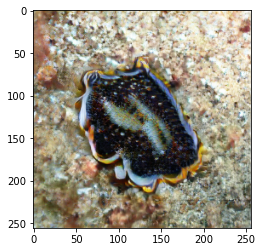

In [9]:
import matplotlib.pyplot as plt

# visual tf2 biggan
plt.imshow((im[0].numpy()+1)/2)

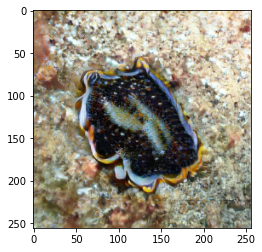

In [10]:
# visual torch biggan
plt.imshow((im_pt[0].permute(1, 2, 0).data.numpy()+1)/2)

In [15]:
# save tf2 weights in cloud bucket
model.save_weights(config['tf2_file'])